# Thử ngồi code hết mấy cái CNN tìm hiểu được 3

##I. Dataset: CIFAR-10

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import torch.nn.functional as F

In [2]:
#Load train and test data
train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ToTensor()]
)
test_transform = transforms.Compose(
    [transforms.Resize((32,32)),
    transforms.ToTensor()]
)
train_data = torchvision.datasets.CIFAR10(root='dataset', train=True,
                                          download=True,
                                          transform=train_transform,
                                          target_transform=None)
test_data = torchvision.datasets.CIFAR10(root='dataset', train=False,
                                         download=True, transform=test_transform,
                                         target_transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(train_data), len(test_data)

(50000, 10000)

In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.1)
               ToTensor()
           )

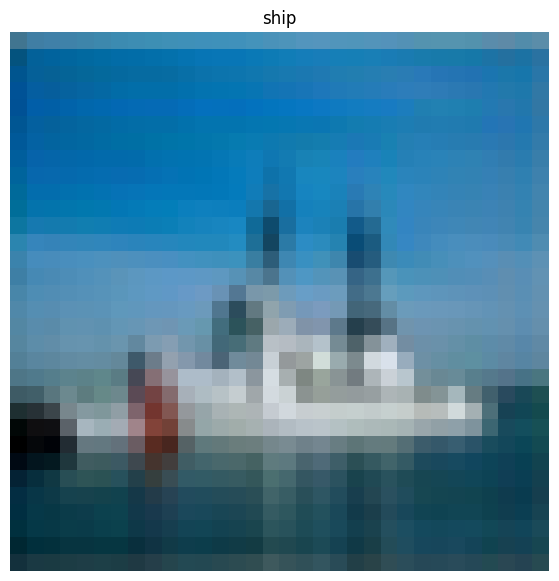

(32, 32, 3)

In [5]:
#Select random image
torch.manual_seed(13)
idx = torch.randint(0 , len(train_data), size  = [1])
image, label = train_data[idx]

#Get image class
class_names = train_data.classes

# Convert (C, H, W) to (H, W, C)
image = image.permute(1,2,0)
image = image.numpy()

#Show image
plt.figure(figsize=(10,7))
plt.axis('off')
plt.imshow(image)
plt.title(class_names[label])
plt.show()
image.shape

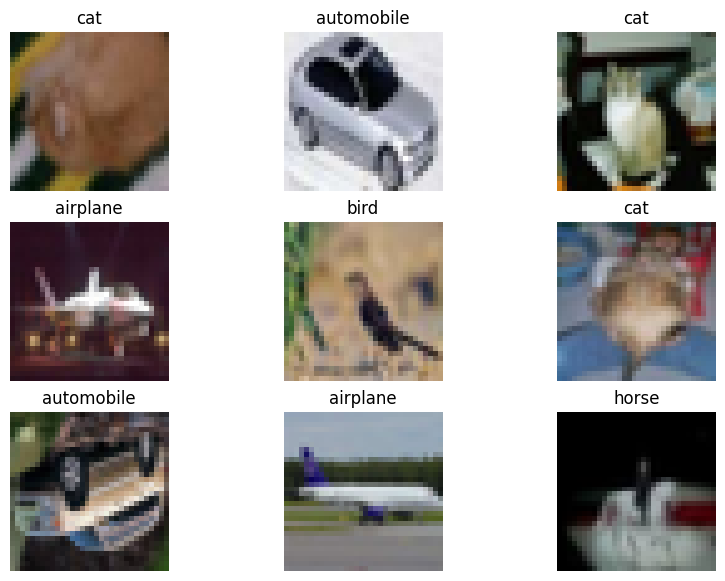

In [6]:
torch.manual_seed(24)
pic = plt.figure(figsize= (10,7))
rows = 3
columns = 3
for i in range(rows * columns):
  idx = torch.randint(0, len(train_data), size=[1])
  image, label = train_data[idx]

  image = image.permute(1,2,0)
  image = image.numpy()
  pic.add_subplot(rows, columns, i+ 1)
  plt.imshow(image)
  plt.title(class_names[label])
  plt.axis('off')
plt.show()

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle=False)


## Get some helper function

In [20]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print("Helper functions already exists, skipping dowload" )
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/huhj225131/SomeCNN/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Helper functions already exists, skipping dowload


In [21]:
from helper_functions import *

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
# Create directory to store models
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok = True)

## CNN

### Model nay toi da may man duoc doc va tim hieu tu mot nguoi ban trong lab cua truong


In [12]:
class residual_block(nn.Module):
  def __init__ (self, layer):
    super().__init__()
    self.layer = layer
  def forward(self, X):
    return X + self.layer(X)

In [13]:
class model_class(nn.Module):
  def __init__(self, in_channels, out_channels, depth, kernel_size = 9, patch_size = 9):
    super().__init__()
    self.conv= nn.Sequential(
        nn.Conv2d(in_channels, 8, kernel_size=kernel_size, stride = patch_size),
        nn.GELU(),
        nn.BatchNorm2d(8)
    )
    self.res = nn.Sequential(*[
            nn.Sequential(
                residual_block(nn.Sequential(
                    nn.Conv2d(8, 8, kernel_size, groups=8, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(8)
                )),
                nn.Conv2d(8, 8, 1),
                nn.GELU(),
                nn.BatchNorm2d(8)
            ) for _ in range(depth)
        ])

    self.linear = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                nn.Flatten(),
                                nn.Linear(8, out_channels))
  def forward(self, X):
    return self.linear(self.res(self.conv(X)))

In [14]:
model = model_class(3, len(class_names),3)

In [15]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model,input_size=[32,3,64,64])

Layer (type:depth-idx)                        Output Shape              Param #
model_class                                   [32, 10]                  --
├─Sequential: 1-1                             [32, 8, 7, 7]             --
│    └─Conv2d: 2-1                            [32, 8, 7, 7]             1,952
│    └─GELU: 2-2                              [32, 8, 7, 7]             --
│    └─BatchNorm2d: 2-3                       [32, 8, 7, 7]             16
├─Sequential: 1-2                             [32, 8, 7, 7]             --
│    └─Sequential: 2-4                        [32, 8, 7, 7]             --
│    │    └─residual_block: 3-1               [32, 8, 7, 7]             672
│    │    └─Conv2d: 3-2                       [32, 8, 7, 7]             72
│    │    └─GELU: 3-3                         [32, 8, 7, 7]             --
│    │    └─BatchNorm2d: 3-4                  [32, 8, 7, 7]             16
│    └─Sequential: 2-5                        [32, 8, 7, 7]             --
│    │    └─resi

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [17]:
#Create save path
MODEL_NAME = "model_2.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/model_2.pth')

In [24]:
_, best_acc = eval_model(model, test_dataloader, loss_fn, accuracy_fn, device )
best_acc


45.7767571884984

In [25]:
train, test = train_test_model(model, train_dataloader,
                 test_dataloader,loss_fn, accuracy_fn, optimizer,MODEL_SAVE_PATH,
                22, device, best_acc)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.555457592010498 | Train accuracy: 43.84596928982725 | Test loss: 1.4993855953216553 | Test_acc: 45.35742811501598
Epoch: 1 | Train loss: 1.5534350872039795 | Train accuracy: 43.54406589891235 | Test loss: 1.5307937860488892 | Test_acc: 45.16773162939297
model tốt đấy, lưu nhé
Epoch: 2 | Train loss: 1.557140827178955 | Train accuracy: 43.72600767754319 | Test loss: 1.496903896331787 | Test_acc: 46.16613418530351
Epoch: 3 | Train loss: 1.5544408559799194 | Train accuracy: 43.6920185540627 | Test loss: 1.5239882469177246 | Test_acc: 44.83825878594249
Epoch: 4 | Train loss: 1.5496747493743896 | Train accuracy: 43.79198656429942 | Test loss: 1.5808217525482178 | Test_acc: 42.98123003194888
Epoch: 5 | Train loss: 1.5453921556472778 | Train accuracy: 43.83797184900832 | Test loss: 1.5454344749450684 | Test_acc: 44.53873801916933
Epoch: 6 | Train loss: 1.5470380783081055 | Train accuracy: 43.91394753678823 | Test loss: 1.5058369636535645 | Test_acc: 45.74680511182109
E